<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate detection of adversarial samples using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate the detection of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.


## Contents

1.	[Loading prereqs and data](#prereqs)
2.  [Evaluating the classifier](#classifier)
3.  [Training the detector](#train_detector)
4.  [Evaluating the detector](#detector)

<a id="prereqs"></a>
## 1. Loading prereqs and data

In [3]:
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]
!pip install h5py==2.10.0

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("\nTensorflow Version: " + tf.__version__)
print("ART Version: " + art.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 86.3 MB 64 kB/s 
     |████████████████████████████████| 3.8 MB 60.6 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 449 kB 49.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 49.1 MB 1.2 MB/s 
     |████████████████████████████████| 249 kB 102.2 MB/s 
     |████████████████████████████████| 551 kB 93.0 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existi

Load the CIFAR10 data set and class descriptions:

In [ ]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 100
num_samples_test = 100
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [ ]:
path = get_file('cifar_resnet.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = tf.keras.models.load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Evaluate the classifier on the first 100 test images:

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 98
Incorrectly classified: 2


For illustration purposes, look at the first 9 images. (In brackets: true labels.)

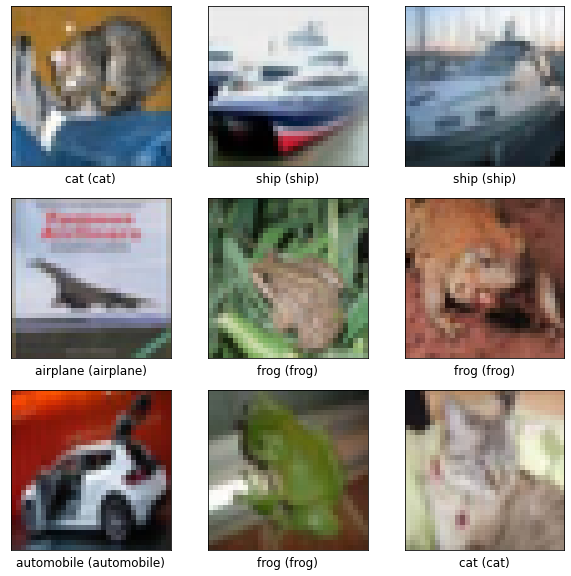

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Generate some adversarial samples:

In [ ]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:100]) # this takes about two minutes

Evaluate the classifier on 100 adversarial samples:

In [ ]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 20
Incorrectly classified: 80


Now plot the adversarial images and their predicted labels (in brackets: true labels).

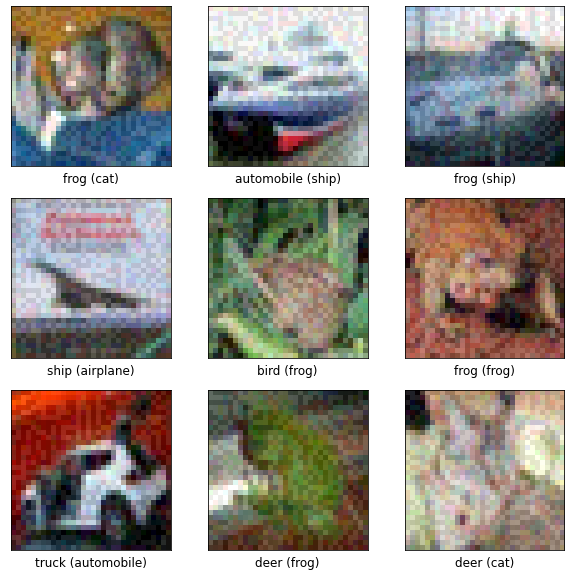

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

<a id="train_detector"></a>
## 3. Training the detector

Load the detector model (which also uses a ResNet architecture):

In [ ]:
path = get_file('BID_eps=0.05.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')
detector_model = tf.keras.models.load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [ ]:
detector_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [ ]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

Perform the training:

In [ ]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20)

Train on 200 samples
Epoch 1/20
200/200 [==============================] - 10s 52ms/sample - loss: 0.0264 - accuracy: 0.9950
Epoch 2/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0583 - accuracy: 0.9800
Epoch 3/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0058 - accuracy: 1.0000
Epoch 4/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0058 - accuracy: 1.0000
Epoch 5/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0059 - accuracy: 1.0000
Epoch 6/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0102 - accuracy: 1.0000
Epoch 7/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0057 - accuracy: 1.0000
Epoch 8/20
200/200 [==============================] - 5s 27ms/sample - loss: 0.0057 - accuracy: 1.0000
Epoch 9/20
200/200 [==============================] - 6s 28ms/sample - loss: 0.0100 - accuracy: 1.0000
Epoch 10/20
200/200 [==============================

<a id="detector"></a>
## 4. Evaluating the detector

Apply the detector to the adversarial test data:

In [ ]:
flag_adv = np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0


Apply the detector to the first 100 original test images:

In [ ]:
flag_original = np.sum(np.argmax(detector.predict(x_test[:100]), axis=1) == 1)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 100
Not flagged: 0


Evaluate the detector for different attack strengths `eps`
(**Note**: for the training of detector, `eps=0.05` was used)

In [ ]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    nb_flag_adv += [np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]
    
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

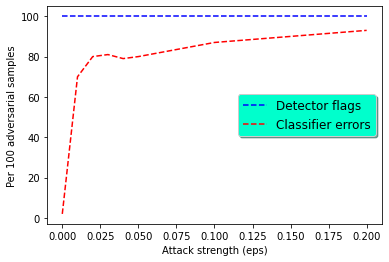

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()